# Computation of the skew in rough Heston

$$
\def\R{\mathbb{R}}
\def\dd{\mathrm{d}}
\def\ii{\mathrm{i}}
$$

We compute the skew in rough Heston using **Fourier pricing**. Recall the definition of rough Heston:
$$
\begin{gather*}
\dd S_t = \sqrt{v_t} S_t \dd Z_t, \quad Z_t = \rho W_t + \sqrt{1-\rho^2} W^\perp_t,\\
v_t = v_0 + \int_0^t K(t-s) \kappa(\theta - v_s) \dd s + \int_0^t K(t-s) \sigma \sqrt{v_s} \dd W_s, \\ 
K(r) \coloneqq \frac{r^{H-1/2}}{\Gamma(H+1/2)}.
\end{gather*}
$$

Further recall that the characteristic function of the log-price $X_t$ is given by
$$
\phi_0(u) \coloneqq \mathbb{E}\left[ \exp\left( \ii u X_T \right) \right] = \exp\left( \ii u X_0 + \int_0^T \xi_t(s)  Q(u, \psi(u, T-s)) \dd s \right),
$$
where $\psi$ solves the fractional Riccati equation
$$
\psi(u, \tau) = K \ast \left( Q(u, \psi(u, \cdot)) - \kappa \psi(u, \cdot)\right)(\tau),\quad Q(u,z) \coloneqq \frac{1}{2} \ii u(\ii u - 1) + \ii \sigma \rho u z + \frac{\sigma^2}{2} z^2.
$$

We start by importing some functions. The code below is largely taken from **Simon Breneis**' public github repository [approximations_to_fractional_stochastic_volterra_equations](https://github.com/SimonBreneis/approximations_to_fractional_stochastic_volterra_equations).

Let us first import some needed packages.

In [2]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial
import matplotlib.pyplot as plt
import time
import psutil
from scipy.special import gamma
from scipy.stats import norm

Next we import the Fourier pricing function from Simon's packages. Note that I have put here a slimmed down version of Simon's full package, containing only the needed functions. We will go through the code one by one.

## Fourier pricing

First, suppose that we are given the characteristic function of the log-price of a stock, and we want to compute the implied volatilities.

#### Integrand in the Fourier domain

In [3]:
def fourier_payoff_call_put(K, u, call=True, digital=False, logarithmic=True):
    """
    Returns the value of the Fourier transform of the payoff of a (digital or standard) 
    put or call option. Is a complex number.
    :param K: Strike price, may also be a numpy array
    :param u: Argument of the Fourier transform
    :param call: If True, returns the Fourier transform of a call option. If False, of a put 
        option
    :param digital: If True, returns the Fourier transform of a digital option. If False, 
        of a standard option
    :param logarithmic: If True, assumes that the payoff is a function of the log-stock price. If False, assumes it is a function of the (normal) stock price
    :return: hat(f)(u) (or hat(f)(K, u) if K is a numpy array)
    """
    u = complex(0, 1) * u
    if digital:
        sign = -1 if call else 1
        if logarithmic:
            if isinstance(K, np.ndarray):
                return sign * np.exp(np.multiply.outer(np.log(K), u)) / u
            return sign * np.exp(np.log(K) * u) / u
        if isinstance(K, np.ndarray):
            return sign * np.exp(np.multiply.outer(K, u)) / u
        return sign * np.exp(K * u) / u
    if logarithmic:
        if isinstance(K, np.ndarray):
            return np.exp(np.multiply.outer(np.log(K), 1 + u)) / (u * (1 + u))
        return np.exp(np.log(K) * (1 + u)) / (u * (1 + u))
    if isinstance(K, np.ndarray):
        return np.exp(np.multiply.outer(K, u)) / u ** 2
    return np.exp(K * u) / u ** 2

#### Compute the price

As discussed in the lecture, we use a variant of Lewis' method, i.e., a proper contour integral. Note that the function assumes the characteristic function of $X_T = \log S_T$ for some fixed maturity $T$ as input, but allows for an array of strike prices $K$.

In [4]:
def price_eur_call_put_fourier(mgf, K, r=0., T=1., R=2., L=50., N=300, log_price=True, 
                               call=True, digital=False):
    """
    Computes the option price of a (digital or standard) European call or put option using 
        Fourier inversion.
    :param mgf: The moment generating function of the log-variable that should be priced 
        (e.g. the final log-price, or the final log-average), a function of the Fourier 
        argument only
    :param R: The (dampening) shift that we use
    :param K: The strike prices, assumed to be a numpy array
    :param r: Interest rate
    :param T: Maturity (only needed for discounting, i.e. if r != 0)
    :param L: The value at which we cut off the integral, so we do not integrate over the 
        reals, but only over [-L, L]
    :param N: The number of points used in the trapezoidal rule for the approximation of 
        the integral
    :param log_price: If True, assumes that the mgf is the mgf of the log-price. If False, 
        assumes it is the mgf of the price (without the logarithm)
    :param call: If True, returns the call price. Else, returns the put price
    :param digital: If True, computes the price of a digital option. Else, of a standard 
        option
    :return: The estimate of the option price
    """
    if call:
        R = np.abs(R)
    else:
        R = - np.abs(R)
    x = np.linspace(0, L, N + 1)
    y = np.zeros(N+1)
    y[:N] = x[1:] - x[:-1]
    y[1:] += x[1:] - x[:-1]
    y /= 2
    mgf_output = np.empty(len(x), dtype=np.cdouble)
    total_rounds = 1
    current_round = 0
    while current_round < total_rounds:
        n_inputs = int(np.ceil(len(x) / total_rounds))
        try:
            mgf_output[current_round * n_inputs:(current_round + 1) * n_inputs] = \
                mgf(R - complex(0, 1) * \
                    x[current_round * n_inputs:(current_round + 1) * n_inputs])
        except MemoryError:
            if total_rounds < len(x):
                total_rounds = total_rounds * 2
                current_round = current_round * 2 - 1
            else:
                raise MemoryError('Not enough memory to carry out Fourier inversion.')
        current_round = current_round + 1
    fourier_payoff = fourier_payoff_call_put(K=K, u=x + complex(0, 1) * R, call=call, 
                                             digital=digital, logarithmic=log_price)
    return np.exp(-r * T) / np.pi * np.real(fourier_payoff @ (mgf_output * y))

#### Compute the implied volatility

This time, we use our own function to compute implied volatilities from prices.

In [5]:
def BS_price_eur_call_put(S_0, K, sigma, T, r=0., call=True, digital=False):
    """
    Computes the price of a (digital or standard) European call or put option under the 
        Black-Scholes model.
    :param S_0: Initial stock price
    :param K: Strike price
    :param sigma: Volatility
    :param r: Drift
    :param T: Final time
    :param call: If True, prices a call option. Else prices a put option
    :param digital: If True, prices a digital option. Else prices a standard option
    :return: The price of a call option
    """
    T = T[..., None] if (isinstance(T, np.ndarray) and len(T.shape) == 1) else T

    def BS_nodes(regularize=True):
        """
        Computes the two nodes of the Black-Scholes model where the CDF is evaluated.
        :param regularize: Ensures that the results are in the interval [-30, 30] to 
            avoid overflow/underflow errors.
        :return: The nodes
        """
        d1_ = (np.log(S_0 / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2_ = (np.log(S_0 / K) + (r - sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        if regularize:
            d1_ = np.fmax(np.fmin(d1_, 30), -30)
            d2_ = np.fmax(np.fmin(d2_, 30), -30)
        return d1_, d2_

    if digital:
        put_price = norm.cdf((np.log(K / S_0) + sigma ** 2 * T / 2 - r * T) / \
                             (sigma * np.sqrt(T)))
        if call:
            return 1 - put_price
        else:
            return put_price
    d1, d2 = BS_nodes()
    if call:
        return S_0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return - S_0 * norm.cdf(-d1) + K * np.exp(-r * T) * norm.cdf(-d2)


In [6]:
def iv(BS_price_fun, price, tol=1e-10, sl=1e-10, sr=10.):
    """
    Computes the implied volatility of an option given its price, assuming the volatility 
        is in [sl, sr].
    :param BS_price_fun: A function of the volatility sigma that returns the corresponding 
        Black-Scholes price
    :param price: (Market) price of the option
    :param tol: Error tolerance in the approximation of the implied volatility
    :param sl: Left point of the search interval
    :param sr: Right point of the search interval
    :return: The implied volatility
    """
    threshold = sl + tol
    sm = (sl + sr) / 2
    while np.amax(sr - sl) > tol:
        em = BS_price_fun(sm) - price
        sl = (em < 0) * sm + (em >= 0) * sl
        sr = (em >= 0) * sm + (em < 0) * sr
        sm = (sl + sr) / 2
    return np.where(sm < threshold, np.nan, sm)

def iv_eur(S_0, K, T, price, payoff, r=0., stat=None):
    """
    Computes the implied volatility of a European call or put option given its price.
    :param S_0: Initial stock price
    :param K: Strike price
    :param r: Drift
    :param T: Final time/maturity
    :param price: (Market) price of the option
    :param payoff: Either 'call' or 'put' or a payoff function taking as input S (final 
        stock price samples) and K (strike or other parameters), and returning the payoffs 
        for all the stock prices S
    :param stat: Can specify a MC error (statistical variance interval). In this case, 
        returns the implied volatility as well as the corresponding MC interval
    :return: The implied volatility
    """
    T = T[..., None] if (isinstance(T, np.ndarray) and len(T.shape) == 1) else T

    if payoff == 'call' or payoff == payoff_call:
        def price_fun(s):
            return BS_price_eur_call_put(S_0=S_0, K=K, sigma=s, r=r, T=T, call=True, 
                                         digital=False)
    elif payoff == 'digital call':
        def price_fun(s):
            return BS_price_eur_call_put(S_0=S_0, K=K, sigma=s, r=r, T=T, call=True, 
                                         digital=True)
    elif payoff == 'put' or payoff == payoff_put:
        def price_fun(s):
            return BS_price_eur_call_put(S_0=S_0, K=K, sigma=s, r=r, T=T, call=False, 
                                         digital=False)
    elif payoff == 'digital put':
        def price_fun(s):
            return BS_price_eur_call_put(S_0=S_0, K=K, sigma=s, r=r, T=T, call=False, 
                                         digital=True)
    else:
        if isinstance(T, np.ndarray):
            normal_rv = np.sqrt(T) * np.random.normal(0, 1, (T.shape[0], 1000000))
        else:
            normal_rv = np.sqrt(T) * np.random.normal(0, 1, 1000000)

        def price_fun(s):
            return np.average(np.exp(-r * T) * \
                              payoff(S=np.exp(s * normal_rv + (r - 0.5 * s ** 2) * T), K=K), 
                              axis=-1)
    if stat is None:
        return iv(BS_price_fun=price_fun, price=price)
    return iv(BS_price_fun=price_fun, price=price), iv(BS_price_fun=price_fun, 
                                                       price=price - stat), \
        iv(BS_price_fun=price_fun, price=price + stat)

def iv_eur_call_put_fourier(mgf, S_0, K, T, r=0., R=2., L=50., N=300, call=True, 
                            digital=False):
    """
    Computes the implied volatility of a (digital or standard) European call or put option 
        using Fourier inversion.
    :param mgf: The moment generating function of the final log-price, a function of the 
        Fourier argument only
    :param S_0: Initial stock price
    :param T: Maturity
    :param r: Drift
    :param R: The (dampening) shift that we use
    :param K: The strike prices, assumed to be a numpy array
    :param L: The value at which we cut off the integral, so we do not integrate over the 
        reals, but only over [-L, L]
    :param N: The number of points used in the trapezoidal rule for the approximation of 
        the integral
    :param call: If True, computes the implied volatility of a call option. Else, of a 
        put option
    :param digital: If True, computes the implied volatility of a digital option. Else, of 
        a standard option
    :return: The estimate of the implied volatility
    """
    payoff = 'call'
    if digital:
        if call:
            payoff = 'digital call'
        else:
            payoff = 'digital put'
    return iv_eur(S_0=S_0, K=K, T=T, 
                  price=price_eur_call_put_fourier(mgf=mgf, K=K, r=r, T=T, R=R, L=L, N=N, 
                                                                      call=True), r=r, 
                  payoff=payoff)

## The characteristic function

Next we need the characteristic function. In what follows, we are going to use the characteristic function of the **Heston model**. Your homework will be to replace this with the characteristic function of the **rough Heston model**.

In [7]:
def solve_fractional_Riccati(F, T, N_Riccati, H=None, nodes=None, weights=None, verbose=0):
    """
    Solves psi(t) = int_0^t K(t - s) F(s, psi(s)) ds.
    :param F: Right-hand side (time-dependent!)
    :param T: Final time
    :param N_Riccati: Number of time steps used for solving the fractional Riccati equation. 
        This is only an initial choice, this number may be adaptively increased if the 
        computation otherwise fails
    :param H: Hurst parameter
    :param nodes: Nodes of the Markovian approximation
    :param weights: Weights of the Markovian approximation
    :param verbose: Determines the number of intermediary results printed to the console
    :return: The solution psi
    """
    dim = len(F(0, 0))
    dt = T / N_Riccati
    available_memory = np.sqrt(psutil.virtual_memory().available)
    necessary_memory = np.sqrt(5 * dim) * np.sqrt(N_Riccati) * \
        np.sqrt(np.array([0.], dtype=np.cdouble).nbytes)
    if necessary_memory > available_memory:
        raise MemoryError(f'Not enough memory to compute the characteristic function of the rough Heston model with'
                          f'{dim} inputs and {N_Riccati} time steps. Roughly {necessary_memory}**2 bytes needed, '
                          f'while only {available_memory}**2 bytes are available.')

    if nodes is None or weights is None:
        coefficient = dt ** (H + 0.5) / gamma(H + 2.5)
        v_1 = coefficient * np.arange(N_Riccati + 1) ** (H + 1.5)
        v_2 = v_1[N_Riccati:1:-1] + v_1[N_Riccati - 2::-1] - 2 * v_1[N_Riccati - 1:0:-1]
        v_3 = v_1[:-1] - coefficient * (np.arange(N_Riccati) - H - 0.5) * \
            np.arange(1, N_Riccati + 1) ** (H + 0.5)

        psi = np.zeros(shape=(dim, N_Riccati + 1), dtype=np.cdouble)
        F_vec = np.zeros(shape=(dim, N_Riccati), dtype=np.cdouble)
        F_vec[:, 0] = F(0, psi[:, 0])
        psi_P = F_vec[:, 0] * (v_3[0] + coefficient)
        psi[:, 1] = F_vec[:, 0] * v_3[0] + coefficient * F(1 / N_Riccati, psi_P)
        for k in range(1, N_Riccati):
            F_vec[:, k] = F(k / N_Riccati, psi[:, k])
            first_summands = F_vec[:, 0] * v_3[k] + F_vec[:, 1:k + 1] @ v_2[-k:]
            psi_P = first_summands + coefficient * F_vec[:, k]
            psi[:, k + 1] = first_summands + coefficient * F((k + 1) / N_Riccati, psi_P)
            if np.amax(np.abs(psi[:, k + 1])) > 1e+70:
                if verbose >= 1:
                    print(f'Increase N_Riccati from {N_Riccati} to {int(N_Riccati * 1.3)}')
                return solve_fractional_Riccati(F=F, T=T, N_Riccati=int(N_Riccati * 1.3), 
                                                H=H, verbose=verbose)

    else:
        nodes, weights = rk.sort(nodes, weights)
        n_zero_nodes = np.sum(nodes < 1e-08)
        N = len(nodes)

        exp_nodes = np.zeros(N)
        temp = nodes * dt
        exp_nodes[temp < 300] = np.exp(-temp[temp < 300])
        div_nodes = np.zeros(N)
        div_nodes[:n_zero_nodes] = dt
        div_nodes[n_zero_nodes:] = (1 - exp_nodes[n_zero_nodes:]) / nodes[n_zero_nodes:]
        div_weights = div_nodes * weights
        new_div = np.sum(div_weights)

        psi_x = np.zeros((dim, N), dtype=np.cdouble)
        psi = np.zeros((dim, N_Riccati + 1), dtype=np.cdouble)

        for i in range(N_Riccati):
            psi_P = new_div * F(i / N_Riccati, psi[:, i]) + psi_x @ exp_nodes
            psi_x = div_weights[None, :] * F((i + 0.5) / N_Riccati, 0.5 * 
                                             (psi[:, i] + psi_P))[:, None] \
                + psi_x * exp_nodes[None, :]
            psi[:, i + 1] = np.sum(psi_x, axis=1)
            if np.amax(np.abs(psi[:, i + 1])) > 1e+70:
                if verbose >= 1:
                    print(f'Increase N_Riccati from {N_Riccati} to {int(N_Riccati * 1.3)}')
                return solve_fractional_Riccati(F=F, T=T, N_Riccati=int(N_Riccati * 1.3), 
                                                H=H, nodes=nodes,
                                                weights=weights, verbose=verbose)

    return psi

def cf_log_price(z, S_0, lambda_, rho, nu, theta, V_0, T, N_Riccati, r=0., H=None, 
                 nodes=None, weights=None, verbose=0):
    """
    Gives the characteristic function of the log-price of the rough Heston model.
    :param z: Argument of the characteristic function (assumed to be a numpy array)
    :param S_0: Initial stock price
    :param lambda_: Mean-reversion speed
    :param rho: Correlation between Brownian motions
    :param nu: Volatility of volatility
    :param theta: Mean variance
    :param V_0: Initial variance
    :param T: Final time
    :param N_Riccati: Number of time steps used for solving the fractional Riccati equation
    :param r: Interest rate
    :param H: Hurst parameter
    :param nodes: Nodes of the Markovian approximation
    :param weights: Weights of the Markovian approximation
    :param verbose: Determines the number of intermediary results printed to the console
    :return: The characteristic function, and the number of time steps N_Riccati that were 
        actually used
    """
    z = complex(0, 1) * z
    a = nu * nu / 2
    b = rho * nu * z - lambda_
    c = (z - 1) * z / 2

    def F(t, x):
        return c + (b + a * x) * x

    psi = solve_fractional_Riccati(F=F, T=T, N_Riccati=N_Riccati, H=H, nodes=nodes, 
                                   weights=weights, verbose=verbose)
    N_Riccati = psi.shape[1] - 1  
    # The function solve_fractional_Riccati may finally use a different number N_Riccati
    integral = np.trapz(psi, dx=T / N_Riccati)
    integral_sq = np.trapz(psi ** 2, dx=T / N_Riccati)
    return np.exp((np.log(S_0) + r * T) * z + V_0 * T * c + 
                  (theta + V_0 * b) * integral + V_0 * a * integral_sq), N_Riccati

## Putting all together

We want to compute the implied volatility surface, and then also the implied volatility skews.

#### Computation of the implied volatilities

In [8]:
def compute_Fourier_inversion(S_0, K, T, fun, rel_tol=1e-03, return_error=False, 
                              H=None, verbose=0):
    """
    Computes the Fourier inversion given a relative error tolerance by finding the 
    appropriate parameters for
    solving the Riccati equations, and computing the inverse Fourier integral.
    :param S_0: Initial stock price
    :param K: Strike price, assumed to be a numpy array (1d or 2d)
    :param T: Numpy array of maturities
    :param fun: Function that computes the Fourier inversion given the numerical parameters. 
        Is a function of
        T_ (single maturity), K_ (array of strikes), N_Riccati (number of Riccati intervals),
        L (cutoff for the Fourier integral), N_Fourier (number of Fourier intervals),
        R (dampening shift that makes the Fourier inversion integrable)
    :param rel_tol: Required maximal relative error in the implied volatility
    :param return_error: If True, also returns a relative error estimate
    :param H: Hurst parameter. Specifying may improve convergence speed
    :param verbose: Determines how many intermediate results are printed to the console
    return: The implied volatility of the call option
    """
    R = 2.  # The (dampening) shift that we use for the Fourier inversion

    def single_maturity(T_, compute, eps):
        """
        Computes the Fourier inversion for a single maturity given a relative error 
            tolerance by finding the appropriate parameters for solving the Riccati 
            equations, and computing the inverse Fourier integral.
        :param T_: Single maturity
        :param compute: Function that computes the Fourier inversion given the numerical 
            parameters for a single maturity. Is a function of
            N_Riccati (number of Riccati intervals), L (cutoff for the Fourier integral),
            N_Fourier (number of Fourier intervals),
            and returns the Fourier inversion, together with the actual number of N_Riccati 
            that was finally used
        :param eps: Relative error tolerance
        return: The implied volatility of the call option
        """
        L = 100 * T_ ** (-0.5 + (0 if H is None else H))  
        # The value at which we cut off the Fourier integral,
        # so we do not integrate over the reals, but only over [0, L]
        N_Riccati = int(10 * L)
        N_Fourier = int(8 * L)  
        # The number of points used in the trapezoidal rule for the approximation of the Fourier
        # integral
        np.seterr(all='warn')
        tic = time.perf_counter()
        smile = compute(N_Riccati=N_Riccati, L=L, N_Fourier=N_Fourier)
        duration = time.perf_counter() - tic
        smile_approx = compute(N_Riccati=int(N_Riccati / 1.6), L=L / 1.2, 
                               N_Fourier=N_Fourier // 2)
        error = np.amax(np.abs(smile_approx - smile) / smile)
        if verbose >= 4:
            print(np.abs(smile_approx - smile) / smile)
        if verbose >= 2:
            print(error)

        while np.isnan(error) or error > eps or np.sum(np.isnan(smile)) > 0:
            if np.sum(np.isnan(smile)) == 0:
                if H is None or H > 0:
                    smile_approx = compute(N_Riccati=int(N_Riccati / 1.8), L=L, 
                                           N_Fourier=N_Fourier)
                    error_Riccati = np.amax(np.abs(smile_approx - smile) / smile)
                    if not np.isnan(error_Riccati) and error_Riccati < eps / 5 and \
                        np.sum(np.isnan(smile_approx)) == 0:
                        N_Riccati = int(N_Riccati / 1.6)
                else:
                    error_Riccati = np.inf

                smile_approx = compute(N_Riccati=N_Riccati, L=L, N_Fourier=N_Fourier // 2)
                error_Fourier = np.amax(np.abs(smile_approx - smile) / smile)
                if not np.isnan(error_Fourier) and error_Fourier < eps / 5 and \
                    np.sum(np.isnan(smile_approx)) == 0:
                    N_Fourier = int(N_Fourier / 1.8)
            else:
                error_Fourier, error_Riccati = np.nan, np.nan

            smile_approx = smile
            if np.sum(np.isnan(smile)) > 0:
                L = L * 1.6
                N_Fourier = int(N_Fourier * 1.7)
                N_Riccati = int(N_Riccati * 2.5)
            else:
                L = L * 1.4
                N_Fourier = int(N_Fourier * 1.4) if error_Fourier < eps / 2 else N_Fourier * 2
                N_Riccati = int(N_Riccati * 1.4) if error_Riccati < eps / 2 else N_Riccati * 2
            if verbose >= 2:
                print(error, error_Fourier, error_Riccati, L, N_Fourier, N_Riccati, duration,
                      time.strftime("%H:%M:%S", time.localtime()))

            tic = time.perf_counter()
            smile = compute(N_Riccati=N_Riccati, L=L, N_Fourier=N_Fourier)
            duration = time.perf_counter() - tic
            error = np.amax(np.abs(smile_approx - smile) / smile)
            if verbose >= 4:
                print(np.abs(smile_approx - smile) / smile)
            if verbose >= 2:
                print(error)

        return smile, error

    T_is_float = False
    if not isinstance(T, np.ndarray):
        T = np.array([T])
        T_is_float = True
    if len(K.shape) == 1:
        K = S_0 * np.exp(np.sqrt(T / T[-1])[:, None] * np.log(K / S_0)[None, :])

    surface = np.empty_like(K)
    errors = np.empty(len(T))
    for i in range(len(T)):
        if verbose >= 1 and len(T) > 1:
            print(f'Now simulating maturity {i+1} of {len(T)}')

        def fun_maturity(N_Riccati, L, N_Fourier):
            return fun(T_=T[i], K_=K[i, :], N_Riccati=N_Riccati, L=L, N_Fourier=N_Fourier, R=R)
        surface[i, :], errors[i] = single_maturity(compute=fun_maturity, T_=T[i],
                                                   eps=rel_tol[i] if isinstance(rel_tol, 
                                                                                np.ndarray) 
                                                   else rel_tol)
    if T_is_float:
        surface = surface[0, :]
        errors = errors[0]
    if return_error:
        return surface, errors
    return surface

#### Implied volatility surface and skew

In [9]:
def eur_call_put(S_0, K, lambda_, rho, nu, theta, V_0, T, r=0., N=0, mode="european", 
                 rel_tol=1e-03, H=None, nodes=None, weights=None, implied_vol=True, 
                 call=True, digital=False, return_error=False, verbose=0):
    """
    Computes the implied volatility or price of a (digital or standard) European call or 
    put option in the rough Heston model.
    Uses Fourier inversion.
    :param S_0: Initial stock price
    :param K: Strike price, assumed to be a numpy array
    :param H: Hurst parameter
    :param lambda_: Mean-reversion speed
    :param rho: Correlation between Brownian motions
    :param nu: Volatility of volatility
    :param theta: Mean variance
    :param V_0: Initial variance
    :param T: Maturity
    :param r: Interest rate
    :param N: Total number of points in the quadrature rule
    :param mode: If observation, uses the parameters from the interpolated numerical optimum. 
        If theorem, uses the parameters from the theorem. If optimized, optimizes over the 
        nodes and weights directly. If best, chooses any of these three options that seems 
        most suitable
    :param rel_tol: Required maximal relative error in the implied volatility
    :param nodes: Can specify the nodes directly
    :param weights: Can specify the weights directly
    :param implied_vol: If True, computes the implied volatility, else computes the price
    :param call: If True, uses the call option, else uses the put option
    :param digital: If True, uses a digital option, else uses a standard option
    :param return_error: If True, also returns a relative maximal error estimate
    :param verbose: Determines how many intermediate results are printed to the console
    return: The implied volatility of the call option
    """
    if N >= 1 and (nodes is None or weights is None):
        nodes, weights = rk.quadrature_rule(H=H, N=N, T=T, mode=mode)

    def mgf(z, T_, N_):
        return cf_log_price(z=complex(0, -1) * z, S_0=S_0, lambda_=lambda_, rho=rho, nu=nu, 
                            theta=theta, r=r, V_0=V_0, T=T_, N_Riccati=N_, H=H, nodes=nodes, 
                            weights=weights, verbose=verbose - 2)[0]

    if implied_vol:
        def compute(T_, K_, N_Riccati, L, N_Fourier, R):
            return iv_eur_call_put_fourier(mgf=lambda u: mgf(z=u, T_=T_, N_=N_Riccati), 
                                           S_0=S_0, K=K_, T=T_, r=r,R=R, L=L, N=N_Fourier, 
                                           digital=digital)
    else:
        def compute(T_, K_, N_Riccati, L, N_Fourier, R):
            return price_eur_call_put_fourier(mgf=lambda u: mgf(z=u, T_=T_, N_=N_Riccati), 
                                              K=K_, T=T_, r=r, R=R, L=L, N=N_Fourier, 
                                              log_price=True, call=call, digital=digital)

    return compute_Fourier_inversion(fun=compute, S_0=S_0, K=K, T=T, rel_tol=rel_tol, 
                                     return_error=return_error, H=H, verbose=verbose)


def skew_eur_call_put(lambda_, rho, nu, theta, V_0, T, r=0., N=0, mode="european", 
                      rel_tol=1e-03, H=None, nodes=None, weights=None, verbose=0):
    """
    Gives the skew of the European call or put option (skew is the same in both cases) in 
    the rough Heston model. Uses Fourier inversion.
    :param H: Hurst parameter
    :param lambda_: Mean-reversion speed
    :param rho: Correlation between Brownian motions
    :param nu: Volatility of volatility
    :param theta: Mean variance
    :param V_0: Initial variance
    :param T: Maturity
    :param r: Interest rate
    :param N: Total number of points in the quadrature rule
    :param mode: If observation, uses the parameters from the interpolated numerical 
        optimum. If theorem, uses the parameters from the theorem. If optimized, optimizes 
        over the nodes and weights directly. If best, chooses any of these three options 
        that seems most suitable
    :param rel_tol: Required maximal relative error in the implied volatility
    :param nodes: Can specify the nodes directly
    :param weights: Can specify the weights directly
    :param verbose: Determines how many intermediate results are printed to the console
    return: The skew of the call option
    """
    if N >= 1 and (nodes is None or weights is None):
        nodes, weights = rk.quadrature_rule(H, N, T, mode)

    def single_skew(T_):

        def compute_smile(eps_, h_):
            if verbose >= 2:
                print(f'Computing smile with {eps_} and {h_}')
            K = np.exp(np.linspace(-200 * h_, 200 * h_, 401))
            smile_, error_ = eur_call_put(S_0=1., K=K, lambda_=lambda_, rho=rho, nu=nu, 
                                          theta=theta, V_0=V_0, T=T_, r=r, N=N, mode=mode, 
                                          rel_tol=eps_, H=H, nodes=nodes, weights=weights, 
                                          implied_vol=True, call=True, return_error=True, 
                                          verbose=verbose - 2)
            return np.array([smile_[198], smile_[199], smile_[201], smile_[202]]), error_

        eps = rel_tol
        h = 0.0005 * np.sqrt(T_)
        smile, eps = compute_smile(eps_=eps, h_=h)
        skew_ = np.abs(smile[2] - smile[1]) / (2 * h)
        skew_h = np.abs(smile[3] - smile[0]) / (4 * h)
        old_eps = eps
        smile, eps = compute_smile(eps_=0.9 * eps, h_=h)
        skew_eps = skew_
        skew_eps_h = skew_h
        skew_ = np.abs(smile[2] - smile[1]) / (2 * h)
        skew_h = np.abs(smile[3] - smile[0]) / (4 * h)
        error = np.abs(skew_eps_h - skew_) / skew_
        error_eps = np.abs(skew_eps - skew_) / skew_
        error_h = np.abs(skew_h - skew_) / skew_
        if verbose >= 2:
            print(error, error_eps, error_h)

        while error > rel_tol:
            if error_eps > rel_tol * 0.8:
                old_eps = eps
                smile, eps = compute_smile(eps_=0.9 * eps, h_=h)
                skew_eps = skew_
                skew_eps_h = skew_h
                skew_ = np.abs(smile[2] - smile[1]) / (2 * h)
                skew_h = np.abs(smile[3] - smile[0]) / (4 * h)
                error = np.abs(skew_eps_h - skew_) / skew_
                error_eps = np.abs(skew_eps - skew_) / skew_
                error_h = np.abs(skew_h - skew_) / skew_
            else:
                h = h / 2
                smile, old_eps = compute_smile(eps_=1.1 * old_eps, h_=h)
                skew_eps = np.abs(smile[2] - smile[1]) / (2 * h)
                skew_eps_h = np.abs(smile[3] - smile[0]) / (4 * h)
                smile, eps = compute_smile(eps_=np.fmin(1.1 * eps, 0.99 * old_eps), h_=h)
                skew_ = np.abs(smile[2] - smile[1]) / (2 * h)
                skew_h = np.abs(smile[3] - smile[0]) / (4 * h)
                error = np.abs(skew_eps_h - skew_) / skew_
                error_eps = np.abs(skew_eps - skew_) / skew_
                error_h = np.abs(skew_h - skew_) / skew_

            if verbose >= 2:
                print(error, error_eps, error_h)
        return skew_

    T_is_float = False
    if not isinstance(T, np.ndarray):
        T = np.array([T])
        T_is_float = True

    skew = np.empty(len(T))
    for i in range(len(T)):
        if verbose >= 1:
            print(f'Now computing skew {i + 1} of {len(T)}')
        skew[i] = single_skew(T_=T[i])
    if T_is_float:
        skew = skew[0]
    return skew


## Finally run some code and plot the results

First we fix the parameters.

In [18]:
S_0 = 1
kappa = 0
rho = -0.7
nu = 0.3
theta = 0.04
V_0 = 0.04
H = 0.1

maturities = np.linspace(0.05, 2, 100)
strikes = S_0 * np.linspace(0.9, 1.2, 100)

#### Implied volatility surface

First we compute the implied volatility surface.

In [22]:
vols = np.empty((len(maturities), len(strikes)))
for i in range(len(maturities)):
    vols[i, :] = eur_call_put(S_0, strikes, kappa, rho, nu, theta, V_0, maturities[i], H=H)

/tmp/ipykernel_30478/1428634637.py:113: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(psi, dx=T / N_Riccati)
/tmp/ipykernel_30478/1428634637.py:114: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_sq = np.trapz(psi ** 2, dx=T / N_Riccati)


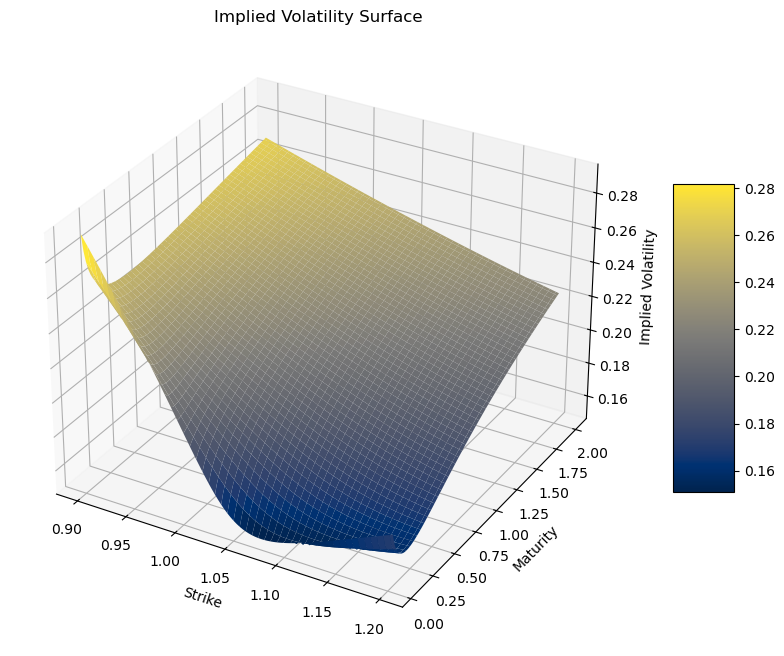

In [23]:
K_mesh, T_mesh = np.meshgrid(strikes, maturities)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.view_init(elev=30, azim=-60)

# Plot the surface
surf = ax.plot_surface(K_mesh, T_mesh, vols, cmap='cividis',
                           linewidth=0, antialiased=True)

# Add labels and title
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface')

# Add a color bar
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

#### Skew

Next, compute the skew.

In [19]:
skew = skew_eur_call_put(kappa, rho, nu, theta, V_0, maturities, r=0., N=0, H=H)

/tmp/ipykernel_30478/1428634637.py:113: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(psi, dx=T / N_Riccati)
/tmp/ipykernel_30478/1428634637.py:114: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_sq = np.trapz(psi ** 2, dx=T / N_Riccati)


Estimate the behaviour of the skew.

In [20]:
new_series = Polynomial.fit(np.log(maturities), np.log(np.abs(skew)), deg=1)
l_alpha, beta = new_series.convert().coef
alpha = np.exp(l_alpha)
print(f"beta = {beta}, H - 1/2 = {H - 0.5}")

beta = -0.5270578545783561, H - 1/2 = -0.4


Plot the skew.

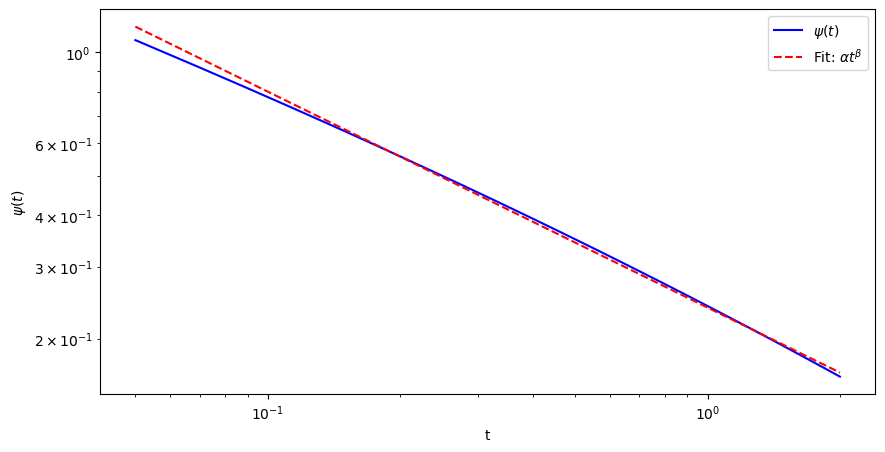

In [21]:
fig, ax  = plt.subplots(figsize=(10,5))
ax.plot(maturities, np.abs(skew), "b-", label=r"$\psi(t)$")
ax.plot(maturities, alpha * maturities ** beta, "r--", label=r"Fit: $\alpha t^{\beta}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("t")
ax.set_ylabel(r"$\psi(t)$")
ax.legend()